### Vector-oriented reasoning
Goal: represent the meaning of words as vectors (word vectors), and represent the meaning of entire documents with those vectors (topic vectors)

TF-IDF to topic vectors projection

### Latent semantic analysis (LSA) on TF-IDF vectors

Semantic analysis and topic modeling works best for short sentences, phras, words.

In [98]:
import pandas as pd

In [99]:
pd.set_option('display.max_columns', 6)
from sklearn.decomposition import PCA
import seaborn

In [100]:
import matplotlib.pyplot as plt
% matplotlib inline

In [101]:
from nlpia.data.loaders import get_data

In [102]:
df = get_data('pointcloud').sample(1000)

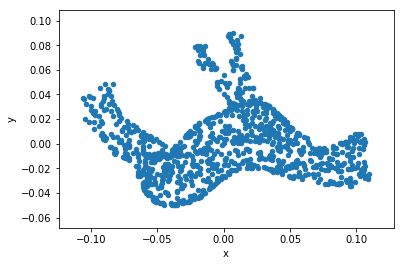

In [103]:
pca = PCA(n_components=2)
df2d = pd.DataFrame(pca.fit_transform(df), columns=list('xy'))
df2d.plot(kind='scatter', x='x', y='y')

Truncated SVD words better for sparse matrics, PCA model is designed to provide a more exact solution using dense solutions.

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize
from nlpia.data.loaders import get_data

sms = get_data('sms-spam')

In [105]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4837 entries, 0 to 4836
Data columns (total 2 columns):
spam    4837 non-null int64
text    4837 non-null object
dtypes: int64(1), object(1)
memory usage: 113.4+ KB


In [106]:
index = ['sms{}{}'.format(i, '!'*j) for (i, j) in zip(range(len(sms)), sms.spam)]

In [107]:
sms = pd.DataFrame(sms.values, columns=sms.columns, index=index)
sms.spam = sms.spam.astype(int)
sms.head(6)

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."
sms5!,1,FreeMsg Hey there darling it's been 3 week's n...


In [108]:
tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=sms.text).toarray()

In [109]:
tfidf_docs.shape

(4837, 9232)

In [110]:
tfidf_docs = tfidf_docs - tfidf_docs.mean()

In [111]:
sms.spam.sum()

638

In [112]:
from sklearn.decomposition import PCA
import time

time1 = time.time()
pca = PCA(n_components=16)
pca = pca.fit(tfidf_docs)
pca_topic_vectors = pca.transform(tfidf_docs)
columns = ['topic{}'.format(i) for i in range(pca.n_components)]
pca_topic_vectors = pd.DataFrame(pca_topic_vectors, columns=columns, index=index)
time2 = time.time()
print(round(time2 - time1,2))

2.52


In [113]:
pca_topic_vectors.round(3).head()

,topic0,topic1,topic2,...,topic13,topic14,topic15
sms0,0.201,0.003,0.037,...,-0.040,-0.015,0.031
sms1,0.404,-0.094,-0.078,...,-0.020,0.053,-0.037
sms2!,-0.030,-0.048,0.090,...,-0.025,-0.046,0.045
sms3,0.329,-0.033,-0.035,...,-0.053,0.028,-0.061
sms4,0.002,0.031,0.038,...,0.025,-0.075,-0.024


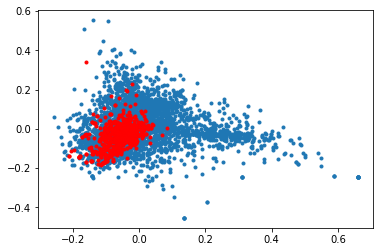

In [114]:
plt.plot(pca_topic_vectors.topic0[sms.spam==0], pca_topic_vectors.topic1[sms.spam==0], '.')
plt.plot(pca_topic_vectors.topic0[sms.spam==1], pca_topic_vectors.topic1[sms.spam==1], 'r.')

In [115]:
from sklearn.decomposition import TruncatedSVD

time1 = time.time()
svd = TruncatedSVD(n_components=16, n_iter=100)
svd_topic_vectors = svd.fit_transform(tfidf_docs)
svd_topic_vectors = pd.DataFrame(data=svd_topic_vectors, columns=columns, index=index)
svd_topic_vectors.round(2).head()
time2 = time.time()
print(round(time2-time1,2))

16.56


#### Note: when using TruncatedSVD to get the principle compoments, we need to make sure that the matrix columns is sample dimension and is properly centered. And it is recommended that for large sample size, Truncated SVD should be used in place of PCA.

To evaluate the performance of LSA, we will calculate the cosine similarity between sentences with the same and different labels.

In [116]:
import numpy as np

In [117]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = pd.DataFrame(cosine_similarity(svd_topic_vectors[:10]), columns=index[:10], index=index[:10])
cos_sim

,sms0,sms1,sms2!,...,sms7,sms8!,sms9!
sms0,1.000000,0.655436,0.120285,...,0.004721,0.033113,0.012718
sms1,0.655436,1.000000,-0.032492,...,-0.061806,0.005005,0.052750
sms2!,0.120285,-0.032492,1.000000,...,0.359602,0.638415,0.529719
sms3,0.686459,0.800438,0.005226,...,-0.096960,0.003638,0.091475
sms4,0.170008,-0.023493,0.294919,...,0.215088,0.020152,0.076742
sms5!,0.123955,0.200853,0.587525,...,0.427042,0.514526,0.592522
sms6,0.116683,0.046890,0.329726,...,0.366477,0.210641,0.220501
sms7,0.004721,-0.061806,0.359602,...,1.000000,0.354571,0.646206
sms8!,0.033113,0.005005,0.638415,...,0.354571,1.000000,0.455076
sms9!,0.012718,0.052750,0.529719,...,0.646206,0.455076,1.000000


In [118]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_train, X_test, y_train, y_test = train_test_split(pca_topic_vectors, sms.spam, test_size=0.5, random_state=100)
lda = LinearDiscriminantAnalysis(n_components=1)
lda = lda.fit(X_train, y_train)
sms['pca_spam'] = lda.predict(pca_topic_vectors)
round(float(lda.score(X_test, y_test)),3)

0.955

In [119]:
sms.head(10)

,spam,text,pca_spam
sms0,0,"Go until jurong point, crazy.. Available only ...",0
sms1,0,Ok lar... Joking wif u oni...,0
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...,1
sms3,0,U dun say so early hor... U c already then say...,0
sms4,0,"Nah I don't think he goes to usf, he lives aro...",0
sms5!,1,FreeMsg Hey there darling it's been 3 week's n...,1
sms6,0,Even my brother is not like to speak with me. ...,0
sms7,0,As per your request 'Melle Melle (Oru Minnamin...,1
sms8!,1,WINNER!! As a valued network customer you have...,1
sms9!,1,Had your mobile 11 months or more? U R entitle...,1


### Latent Dirichlet Allocation (LDiA)

In [120]:
total_corpus_len = 0
for document_text in sms.text:
    total_corpus_len += len(casual_tokenize(document_text))
mean_document_len = total_corpus_len / len(sms)
round(mean_document_len, 2)

21.35

LDiA works best with raw BOW count vectors rather than normalized TF-IDF vector

In [121]:
from sklearn.feature_extraction.text import CountVectorizer
counter = CountVectorizer(tokenizer=casual_tokenize)
count_token = counter.fit_transform(raw_documents=sms.text).toarray()
bow_docs = pd.DataFrame(count_token, index=index)
column_nums, terms = zip(*sorted(zip(counter.vocabulary_.values(), counter.vocabulary_.keys())))
bow_docs.columns = terms

In [122]:
bow_docs.head()

,!,"""",#,...,┾,〨ud,鈥
sms0,0,0,0,...,0,0,0
sms1,0,0,0,...,0,0,0
sms2!,0,0,0,...,0,0,0
sms3,0,0,0,...,0,0,0
sms4,0,0,0,...,0,0,0


In [123]:
count_token

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [124]:
sms.loc['sms0'].text

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [125]:
bow_docs.loc['sms0'][bow_docs.loc['sms0'] > 0].head()

,            1
..           1
...          2
amore        1
available    1
Name: sms0, dtype: int64

In [126]:
from sklearn.decomposition import LatentDirichletAllocation as LDiA

ldia = LDiA(n_components=16, learning_method='batch')
ldia = ldia.fit(bow_docs)
ldia.components_.shape

(16, 9232)

In [127]:
components = pd.DataFrame(ldia.components_.T, index=terms, columns=columns)
components.round(2).head()

,topic0,topic1,topic2,...,topic13,topic14,topic15
!,242.89,235.65,0.06,...,7.35,22.03,26.16
"""",38.19,18.22,6.13,...,0.06,0.06,113.70
#,6.06,0.06,1.06,...,0.06,0.06,0.06
#150,0.06,0.06,0.06,...,0.06,0.06,0.06
#5000,0.06,1.06,0.06,...,0.06,0.06,0.06


In [128]:
ldia_topic_vectors = ldia.transform(bow_docs)
ldia_topic_vectors = pd.DataFrame(ldia_topic_vectors, columns=columns, index=index)
ldia_topic_vectors.round(2).head()

,topic0,topic1,topic2,...,topic13,topic14,topic15
sms0,0.55,0.00,0.00,...,0.00,0.00,0.00
sms1,0.01,0.01,0.01,...,0.01,0.01,0.01
sms2!,0.00,0.00,0.00,...,0.98,0.00,0.00
sms3,0.00,0.00,0.00,...,0.00,0.00,0.00
sms4,0.00,0.00,0.00,...,0.00,0.00,0.00


In [129]:
X_train, X_test, y_train, y_test = train_test_split(ldia_topic_vectors, sms.spam, test_size=0.5, random_state= 101)
lda = LinearDiscriminantAnalysis(n_components=1)
lda = lda.fit(X_train, y_train)
sms['ldia_spam'] = lda.predict(ldia_topic_vectors)
print(round(float(lda.score(X_test, y_test)), 2))

0.92


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


By looking at the similarity between high dimension tf-idf vectors and vectors after LSA analysis, we could have some idea about how the dimensionality reduction is performing. 

It turns out that LSA preserves large distances, but does not always preserve close distances. 

With previous methods, we performed dimensionality reduction first with either LSA or LDiA 

According to the understanding of sample size and dimension, LDA after LSA/LDiA will be less likely to overfit.

In [134]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda = lda.fit(tfidf_docs, sms.spam)
# tfidf_docs['lda_spaminess'] = lda.predict(tfidf_docs)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(lda, tfidf_docs, sms.spam, cv=5)

In [133]:
"Accuracy: {:.2f} (+/-{:.2f})".format(scores.mean(), scores.std()*2)

'Accuracy: 0.63 (+/-0.04)'

In [138]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_docs, sms.spam, test_size=0.33, random_state=10)
lda = LinearDiscriminantAnalysis(n_components=1)
lda = lda.fit(X_train, y_train)
print(round(float(lda.score(X_test, y_test)), 3))

/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.912


In [141]:
scores = cross_val_score(lda, pca_topic_vectors, sms.spam, cv=10)
"accuracy: {:0.3f} (+/-{:.3f})".format(scores.mean(), scores.std()*2)

'accuracy: 0.956 (+/-0.022)'

### Topic Vector Power and Semantic Search